In [63]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import cv2
import os
import random

In [64]:
input_img = cv2.imread('C:/Users/Aaditya/Documents/Projects/rl/images/set/frame15787.jpg')

In [65]:
def calculate_features(image):

    fast12 = cv2.FastFeatureDetector_create(nonmaxSuppression = True)

    keypoints = fast12.detect(image, None)

    # Draw the detected keypoints on the image
    output_image = cv2.drawKeypoints(image, keypoints, None, color=(0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    # Count the number of detected features
    num_features = len(keypoints)
    # print(f"Number of FAST-12 features detected: {num_features}")

    # Display the image with keypoints
    # plt.imshow(output_image)
    return num_features

calculate_features(input_img)


1270

In [66]:
# Define the list of image enhancement algorithms
image_enhancement_algorithms = ['WB','C_Up','C_Down','Bs_Up','B_Down','CLAHE']

# Define state space (number of features in intervals of hundreds)
state_space = ['F0','F1','F2','F3','F4','F5']

# # Define the environment (for simplicity, we assume a deterministic environment)
# def get_features(image, algorithm):
#     # Simulated function to compute the number of features
#     if algorithm == "Algorithm1":
#         return 2 * image  # Adjust this for different algorithms
#     elif algorithm == "Algorithm2":
#         return 3 * image
#     elif algorithm == "Algorithm3":
#         return 4 * image

In [67]:
# Define the REINFORCE policy network
class PolicyNetwork(tf.keras.Model):
    def __init__(self, num_actions):
        super(PolicyNetwork, self).__init__()
        self.dense1 = tf.keras.layers.Dense(32, activation='relu')
        self.dense2 = tf.keras.layers.Dense(num_actions, activation='softmax')

    def call(self, state):
        x = self.dense1(state)
        return self.dense2(x)

# Create the policy network and optimizer
policy_net = PolicyNetwork(len(image_enhancement_algorithms))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [68]:
def CLAHE(image):

    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

    clahe_image = clahe.apply(gray_image)

    if len(image.shape) == 3:
        clahe_image = cv2.cvtColor(clahe_image, cv2.COLOR_GRAY2BGR)

    return clahe_image

In [69]:
def white_balance(image):
   
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    l, a, b = cv2.split(lab_image)

    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)

    balanced_lab_image = cv2.merge((cl, a, b))

    balanced_image = cv2.cvtColor(balanced_lab_image, cv2.COLOR_LAB2BGR)

    return balanced_image

In [70]:
def Contrast_Up(image):
    
    contrasted_image = cv2.convertScaleAbs(image, alpha=4.0, beta=0)
    return contrasted_image

def Contrast_Down(image):
    
    contrasted_image = cv2.convertScaleAbs(image, alpha=0.2, beta=0)
    return contrasted_image

def Brightness_Up(image):
    
    brightened_image = cv2.convertScaleAbs(image, alpha=1.0, beta=150)
    return brightened_image

def Brightness_Down(image):
    
    darkened_image = cv2.convertScaleAbs(image, alpha=1.0, beta=10)
    return darkened_image

In [71]:
def perform_action(ind,img_inp):
        if ind == 0:
            denoised = white_balance(img_inp)
            return denoised
        elif ind == 1:
            denoised = Contrast_Up(img_inp)
            return denoised
        
        elif ind == 2:
            denoised = Contrast_Down(img_inp)
            return denoised
        elif ind == 3:
            denoised = Brightness_Up(img_inp)
            return denoised
        elif ind == 4:
            denoised = Brightness_Down(img_inp)
            return denoised
        elif ind == 5:
            denoised = CLAHE(img_inp)
            return denoised

In [72]:
def check_state(image):
        num_of_features = calculate_features(image)
        if num_of_features < 0:
            return 'F0'
        elif num_of_features >= 0 and num_of_features < 100 :
            return 'F1'
        elif num_of_features <=200 and num_of_features > 100:
            return 'F2'
        elif num_of_features <=300 and num_of_features > 200:
            return 'F3'
        elif num_of_features <=400 and num_of_features > 300:
            return 'F4'
        elif  num_of_features > 400:
            return 'F5'

In [73]:
def next_state(image ,action):
        next_img = perform_action(action,image)

        return [next_img,check_state(next_img)]

In [74]:
def get_feature_value(ft1):
        i1 = state_space.index(ft1)
        return i1*100

In [75]:
def update_reward(img1,img2):
        feature_difference = calculate_features(img1) - calculate_features(img2)
        
        if feature_difference <0:
            return -5
        elif feature_difference == 0:
            return -1
        elif feature_difference <= 100 and feature_difference > 0:
            return 1
        elif feature_difference <= 200 and feature_difference > 100:
            return 2
        elif feature_difference <= 300 and feature_difference > 200:
            return 3
        elif feature_difference <= 400 and feature_difference > 300:
            return 4
        elif feature_difference > 400 :
            return 5

In [76]:
# Define the training loop
def train_REINFORCE(num_episodes, discount_factor,input_img):
    cumulative_reward = 0
    
    for episode in range(num_episodes):
        state = np.random.choice(state_space)  # Random initial state
        state_tensor = tf.constant([[get_feature_value(state)]], dtype=tf.float32)

        curr_image = input_img

        with tf.GradientTape() as tape:
            action_probs = policy_net(state_tensor)
            action_distribution = tfp.distributions.Categorical(probs=action_probs)
            action = action_distribution.sample()
            action = int(action.numpy())

            if action == 0:
                nxt_state =  next_state(curr_image,0)
                next_state_tensor = tf.constant([[get_feature_value(nxt_state[1])]], dtype=tf.float32)
                den_img = nxt_state[0]
                reward = update_reward(den_img,curr_image)
                cumulative_reward += reward
                    
            elif action == 1:
                nxt_state =  next_state(curr_image,1)
                next_state_tensor = tf.constant([[get_feature_value(nxt_state[1])]], dtype=tf.float32)
                den_img = nxt_state[0]
                reward = update_reward(den_img,curr_image)
                cumulative_reward += reward
                    
            elif action == 2:
                nxt_state =  next_state(curr_image,2)
                next_state_tensor = tf.constant([[get_feature_value(nxt_state[1])]], dtype=tf.float32)
                den_img = nxt_state[0]
                reward = update_reward(den_img,curr_image)
                cumulative_reward += reward
                    
            elif action == 3:
                nxt_state =  next_state(curr_image,3)
                next_state_tensor = tf.constant([[get_feature_value(nxt_state[1])]], dtype=tf.float32)
                den_img = nxt_state[0]
                reward = update_reward(den_img,curr_image)
                cumulative_reward += reward
                    
            elif action == 4:
                nxt_state =  next_state(curr_image,4)
                next_state_tensor = tf.constant([[get_feature_value(nxt_state[1])]], dtype=tf.float32)
                den_img = nxt_state[0]
                reward = update_reward(den_img,curr_image)
                cumulative_reward += reward
                    
            elif action == 5:
                nxt_state =  next_state(curr_image,5)
                next_state_tensor = tf.constant([[get_feature_value(nxt_state[1])]], dtype=tf.float32)
                den_img = nxt_state[0]
                reward = update_reward(den_img,curr_image)
                cumulative_reward += reward
                    

            

            # Compute the loss
            loss = -tf.math.log(action_probs[0][action]) * reward

            curr_image = den_img
            end_ep_features = calculate_features(den_img)

        plt.imshow(curr_image)

        # Compute gradients and update the policy network
        grads = tape.gradient(loss, policy_net.trainable_variables)
        optimizer.apply_gradients(zip(grads, policy_net.trainable_variables))

        # Print episode information
        print(f"Episode {episode + 1}: State={state}, Action={image_enhancement_algorithms[action]}, Reward={reward},Cumulative={cumulative_reward}")


Episode 1: State=F1, Action=C_Down, Reward=-5,Cumulative=-5
Episode 2: State=F1, Action=B_Down, Reward=-1,Cumulative=-6
Episode 3: State=F1, Action=B_Down, Reward=-1,Cumulative=-7
Episode 4: State=F1, Action=C_Up, Reward=-5,Cumulative=-12
Episode 5: State=F3, Action=B_Down, Reward=-1,Cumulative=-13
Episode 6: State=F3, Action=B_Down, Reward=-1,Cumulative=-14
Episode 7: State=F4, Action=B_Down, Reward=-1,Cumulative=-15
Episode 8: State=F4, Action=B_Down, Reward=-1,Cumulative=-16
Episode 9: State=F1, Action=B_Down, Reward=-1,Cumulative=-17
Episode 10: State=F3, Action=B_Down, Reward=-1,Cumulative=-18
Episode 11: State=F4, Action=B_Down, Reward=-1,Cumulative=-19
Episode 12: State=F1, Action=B_Down, Reward=-1,Cumulative=-20
Episode 13: State=F3, Action=B_Down, Reward=-1,Cumulative=-21
Episode 14: State=F3, Action=B_Down, Reward=-1,Cumulative=-22
Episode 15: State=F0, Action=B_Down, Reward=-1,Cumulative=-23
Episode 16: State=F0, Action=B_Down, Reward=-1,Cumulative=-24
Episode 17: State=F1, 

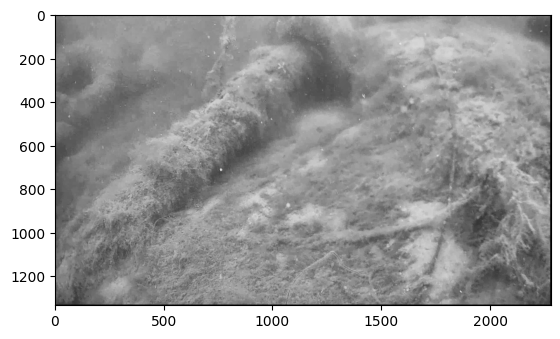

In [77]:
# Training parameters
num_episodes = 1000
discount_factor = 0.99

# Train the agent
train_REINFORCE(num_episodes, discount_factor,input_img)